In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NTK Beamforming


In [7]:
import numpy as np
import h5py
f = h5py.File('/opt/projects/generally_intelligent/standalone/llms/1_48_tofu_milk_doppler_10_100.mat','r')
# # data = f.get('data/variable1')
# # data = np.array(data) # For converting to a NumPy array

# import numpy as np
# import scipy.io
# mat = scipy.io.loadmat('1_48_tofu_purple_straw_single_angle.mat')
raw_rf_data = np.array(f[f['RcvData'][0,0]]).transpose((2,1,0))

In [18]:
43008/2048

21.0

In [11]:
aperture_permutation = [22,21,20,40,23,41,45,42,44,43,46,17,16,47,12,19,18,13,14,15,48,49,53,50,52,51,8,54,55,10,11,4,5,6,7,9,3,2,1,0,39,38,37,36,32,33,34,35]
len(aperture_permutation)

48

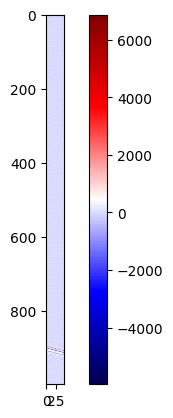

In [22]:
import matplotlib.pyplot as plt
plt.imshow(raw_rf_data[2048*3:2048*3+1000,aperture_permutation,0], cmap="seismic")
plt.colorbar()
plt.show()

In [24]:
from imaging.demodulate import demodulate_rf_to_iq

transducer_frequency = 2.5e6 # default verasonics is 2.5MHz
freq_sampling = 4 * transducer_frequency
iq_signals, freq_carrier = demodulate_rf_to_iq(
    raw_rf_data[2048*3:2048*3+1000,aperture_permutation,0], freq_sampling, freq_carrier=transducer_frequency
)

freq_carrier

2500000.0

In [27]:
N = 220
Nz = 200
dx0 = 2.95e-4

nelements = 48

# Generate 1D arrays for x and z
x = np.linspace(-(N // 2) * dx0, (N // 2) * dx0, N)
z = np.linspace(0, Nz * dx0, Nz)

# Create 2D meshgrid for x and z
X, Z = np.meshgrid(x, z)

N, Nz, dx0

(220, 200, 0.000295)

In [28]:
from imaging.beamform import beamform_delay_and_sum

beamformed_signal = beamform_delay_and_sum(
    iq_signals,
    X,
    Z,
    freq_sampling,
    freq_carrier,
    pitch=dx0,
    tx_delays=np.zeros(nelements),
)

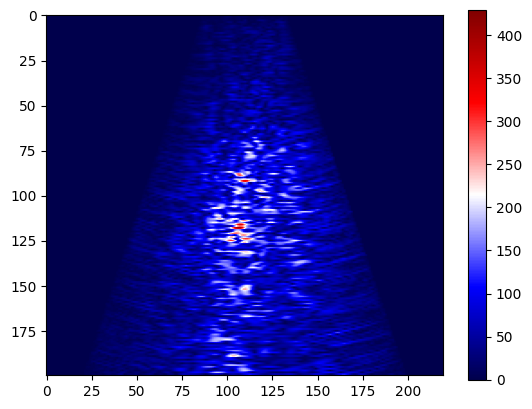

In [29]:
plt.imshow(np.abs(beamformed_signal), cmap="seismic")
plt.colorbar()
plt.show()

In [32]:
all_beamformed_signals = []
for i in range(600):
    iq_signals, freq_carrier = demodulate_rf_to_iq(
        raw_rf_data[2048*3:2048*3+1000,aperture_permutation,i], freq_sampling, freq_carrier=transducer_frequency
    )
    beamformed_signal = beamform_delay_and_sum(
        iq_signals,
        X,
        Z,
        freq_sampling,
        freq_carrier,
        pitch=dx0,
        tx_delays=np.zeros(nelements),
    )
    all_beamformed_signals.append(beamformed_signal)
    if i % 50 == 0:
        print(f"done with {i}")
all_beamformed_signals = np.array(all_beamformed_signals)

all_beamformed_signals.shape

done with 0
done with 10
done with 20
done with 30
done with 40


(50, 200, 220)

In [ ]:
def power_doppler(start_frame, end_frame):
    # start and end frames are indices. frame rate is around 60 Hz
    fft_data = np.fft.fft(all_beamformed_signals[start_frame:end_frame], axis=0)
    freqs = np.fft.fftfreq(end_frame - start_frame, 1/freq_sampling)
    high_pass = fft_data[abs(freqs)> 1540 / (4e-3)] # 1540 m/s is speed of sound, 4e-3 m/s is tissue slow movements
    return np.sum(np.abs(high_pass)**2,axis=0)

power = power_doppler(12, 24)
power.shape

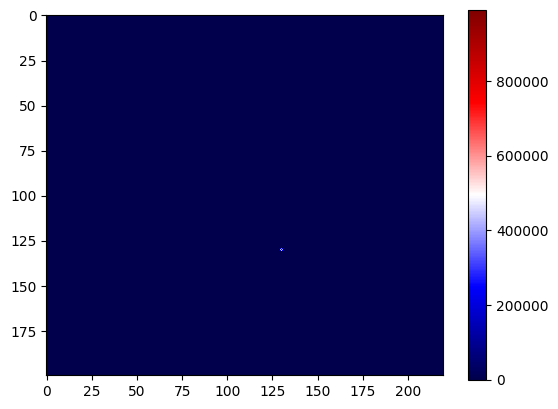

In [50]:
plt.imshow(np.abs(power), cmap="seismic")
plt.colorbar()
plt.show()

385000.0